# HW6

Name: Xulai Wu <br>
Github Username: LukeWu5121 <br>
USC ID: 6591102106

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

## 1. Tree-Based Methods

### a&b).

#### i).

After research, for missing value, we have several data imputation techniques: Mean imputation/Median imputation/Mode Imputation, we also have KNN imputation/Iterative Imputation and so on

For Here, we choose Mean Imputation

In [52]:
train_df = pd.read_csv("../Data/aps_failure_training_set.csv", na_values="na", skiprows=20)
test_df = pd.read_csv("../Data/aps_failure_test_set.csv", na_values="na", skiprows=20)
labels = train_df['class']
labels = labels.replace({'neg': 0, 'pos': 1})
train_features = train_df.drop(columns='class')
test_features = test_df.drop(columns='class')

#Find the mean value of each feature in the test set
test_means = test_features.mean()
train_features_imputed = train_features.fillna(test_means)
train_imputed = train_features_imputed.copy()
train_imputed['class'] = labels

C:\Users\wuxul\AppData\Local\Temp\ipykernel_63884\37246693.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels = labels.replace({'neg': 0, 'pos': 1})


#### ii & iii).

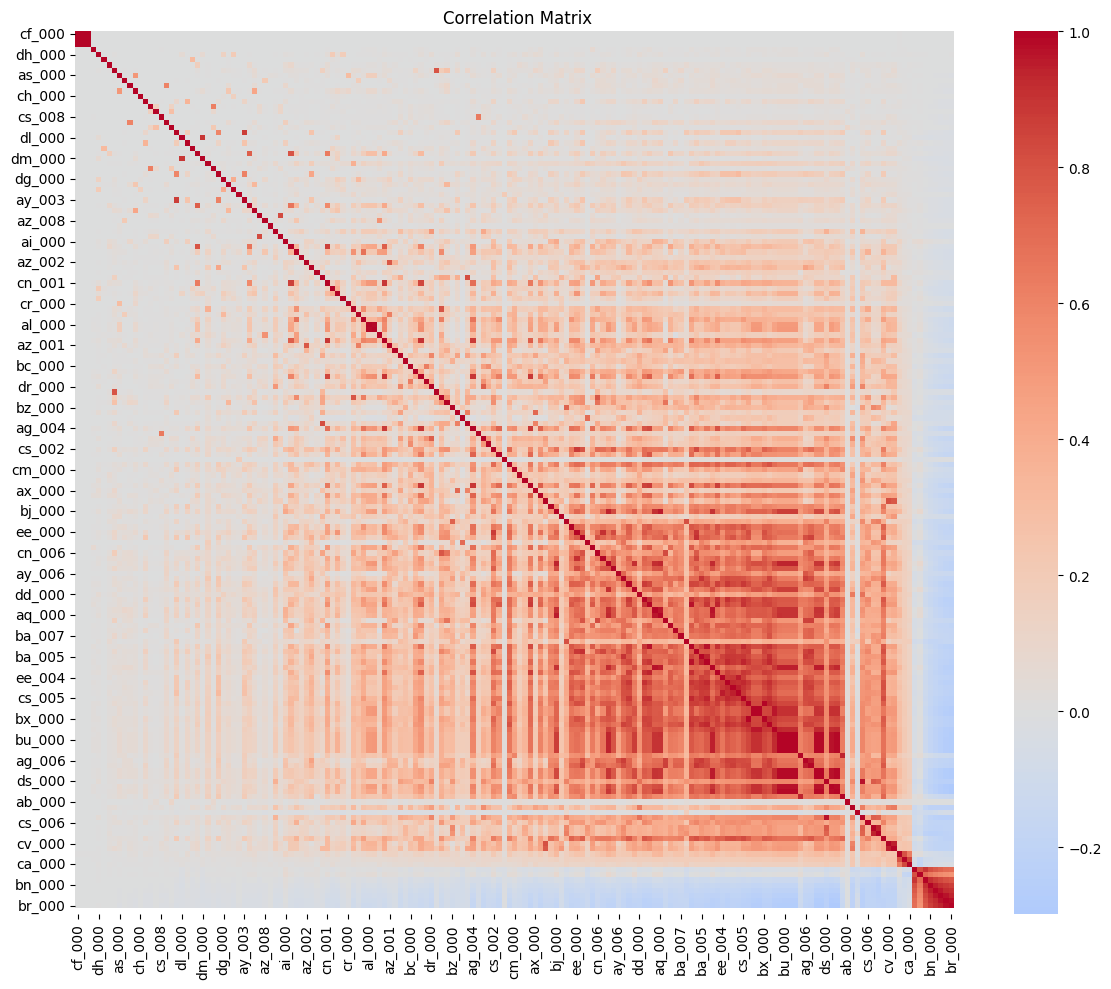

In [53]:
features_only = train_imputed.drop(columns='class')

std = features_only.std()
mean = features_only.mean()
cv = std / mean

top_cv_features = cv.sort_values(ascending=False).index
corr_matrix = features_only[top_cv_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, fmt=".2f", center=0)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


#### iv).

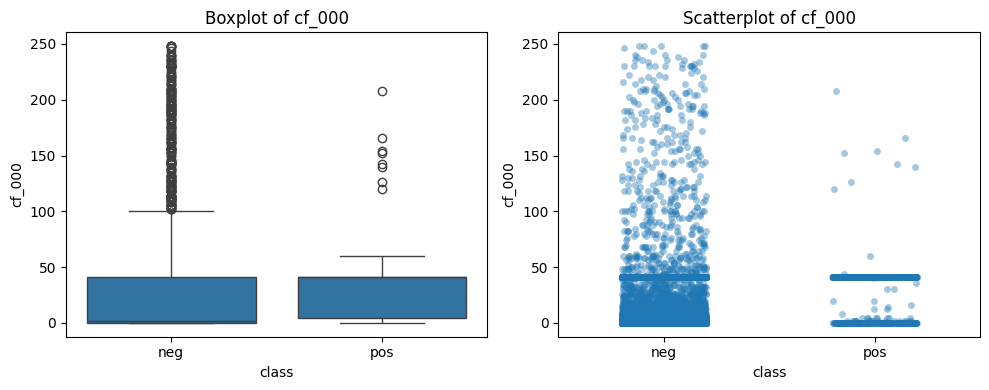

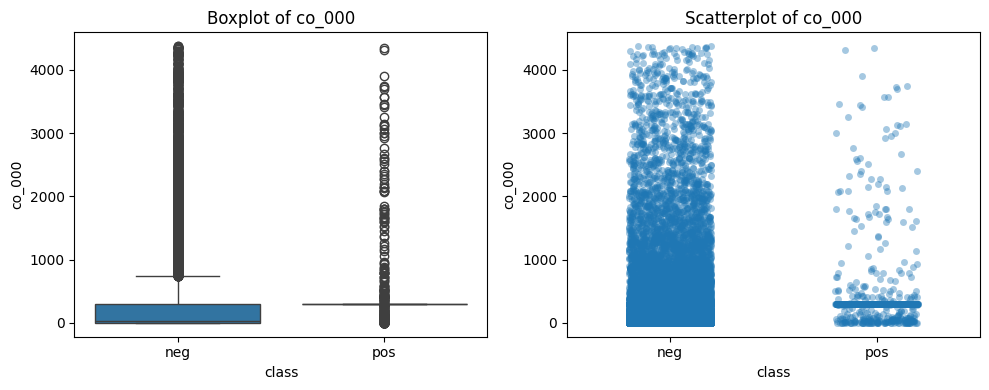

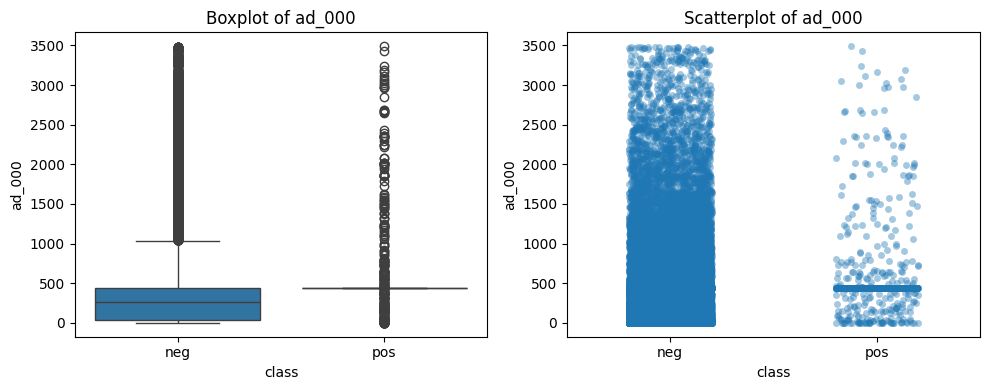

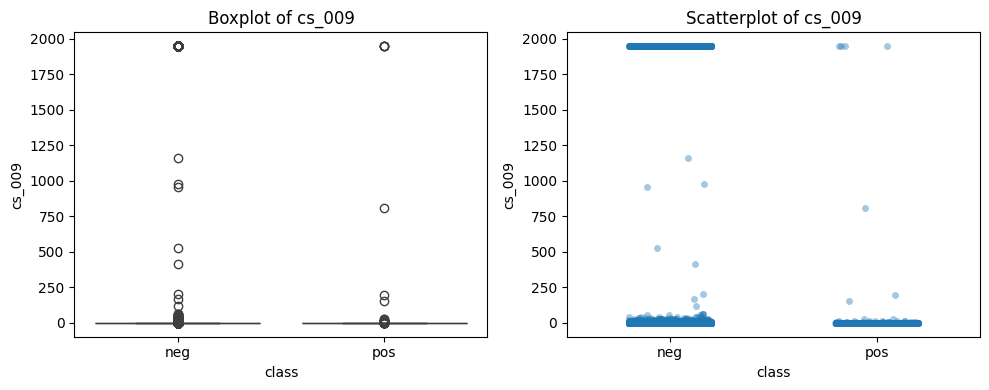

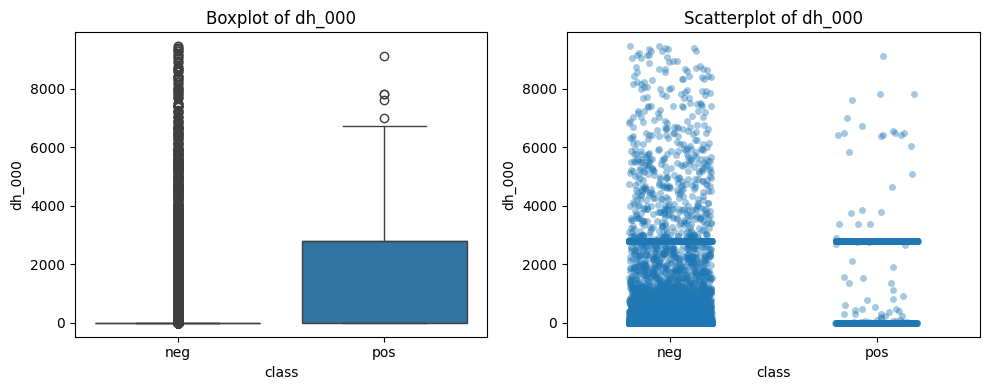

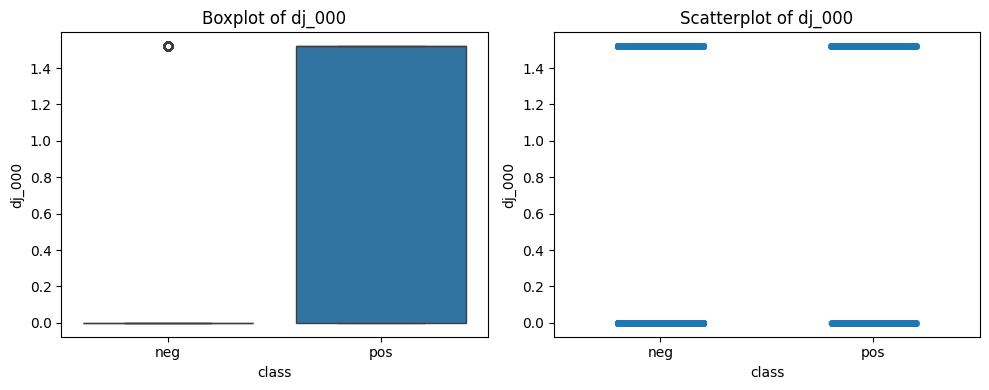

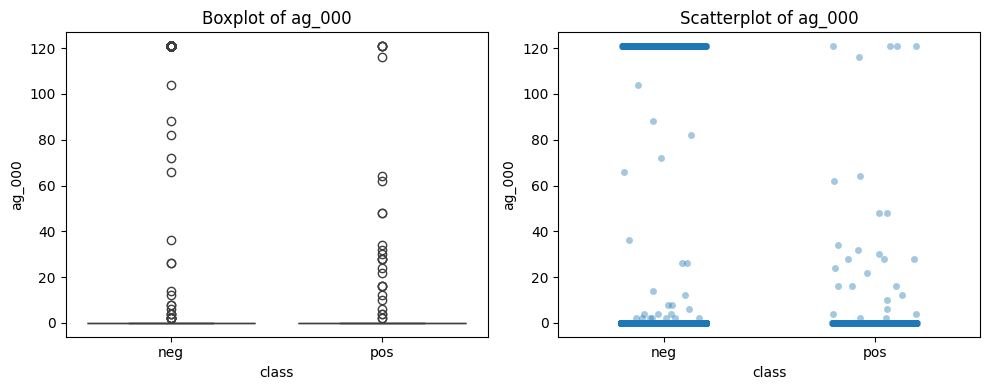

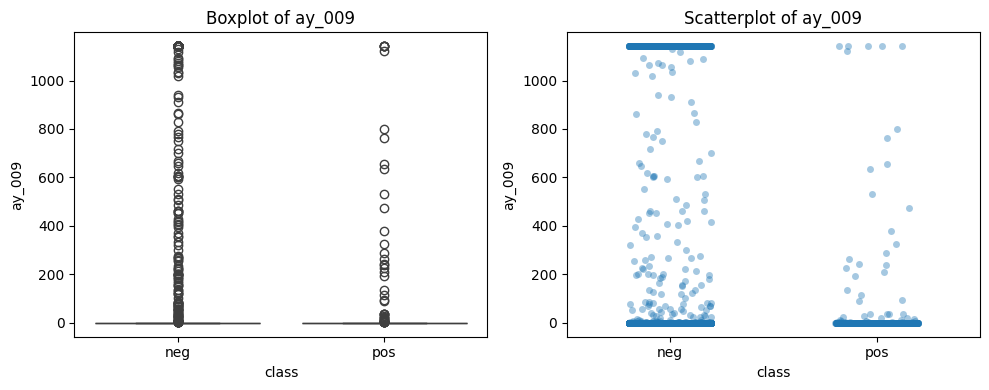

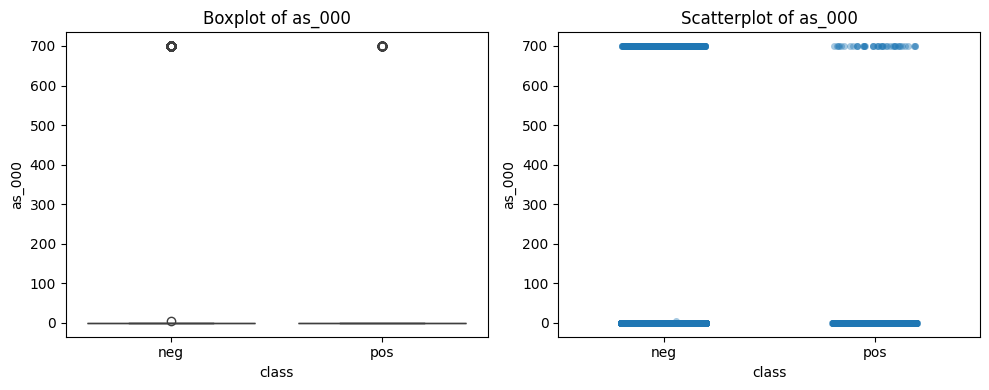

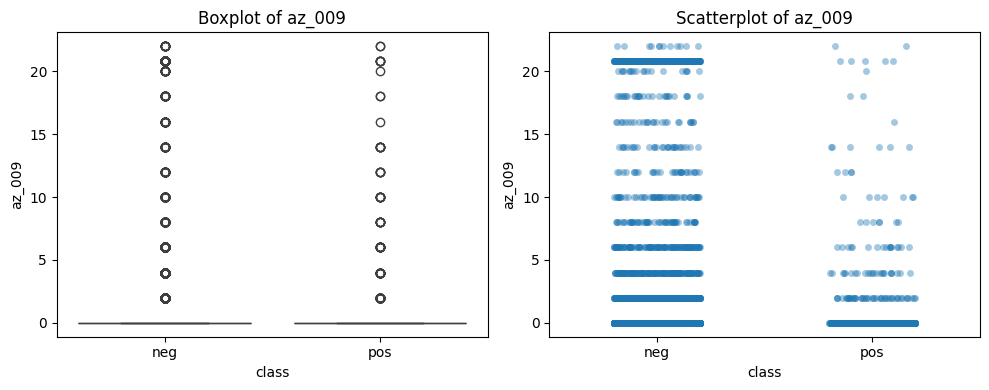

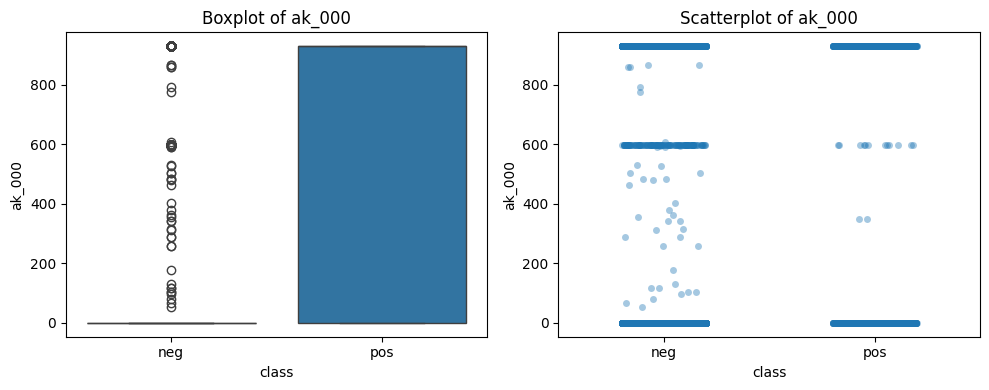

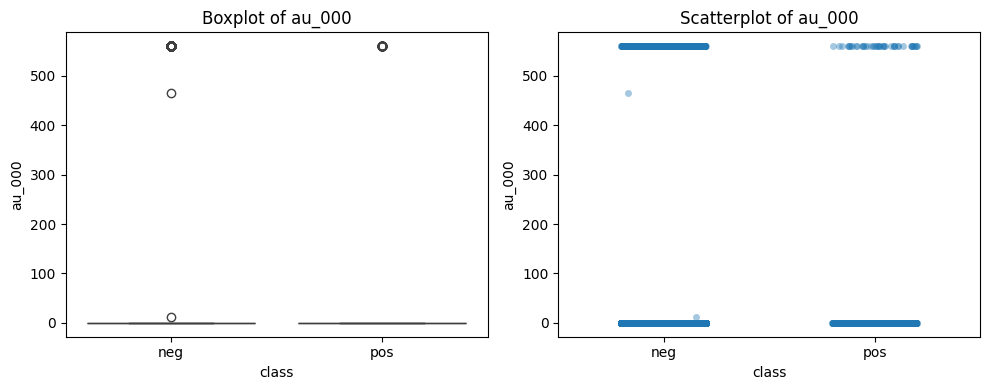

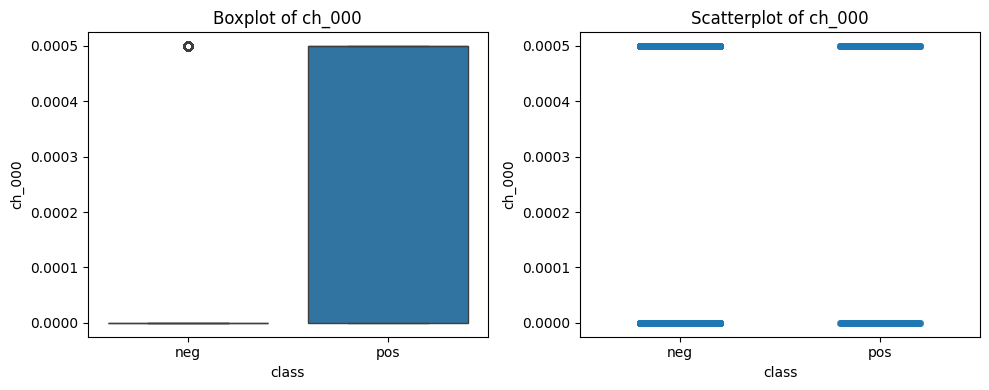

In [54]:
#Square root of 170 ~ 13.0384
top_13_features = cv.sort_values(ascending=False).head(13).index
plot_df = train_imputed.copy()
plot_df['class'] = train_df['class'].astype('category')

for feature in top_13_features:
    plt.figure(figsize=(10, 4))
    #Set the limit so it won't influence the boxplot and scatterplot too much
    upper_limit = plot_df[feature].quantile(0.99)
    subset = plot_df[plot_df[feature] <= upper_limit]

    # Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(x='class', y=feature, data=subset)
    plt.title(f'Boxplot of {feature}')

    # Scatterplot
    plt.subplot(1, 2, 2)
    sns.stripplot(x='class', y=feature, data=subset, jitter=0.2, alpha=0.4)
    plt.title(f'Scatterplot of {feature}')

    plt.tight_layout()
    plt.show()


We can draw some conclusion, for most of the feature we pick here, they have big influence. But for feature like au_000 and as_000, it does not have much influence, most of the data here are extreme value.

#### v).

In [55]:
count_data = train_df['class'].value_counts()
print(count_data)

class
neg    59000
pos     1000
Name: count, dtype: int64


There are much more negative data than positive data, so it is imbalanced.

## c).

In [56]:
x_train = train_imputed.drop(columns='class')
y_train = train_imputed['class'].astype(int)
x_test = test_df.drop(columns='class')
y_test = test_df['class'].replace({'neg': 0, 'pos': 1}).astype(int)

rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
rf.fit(x_train, y_train)

C:\Users\wuxul\AppData\Local\Temp\ipykernel_63884\3516584261.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test = test_df['class'].replace({'neg': 0, 'pos': 1}).astype(int)


RandomForestClassifier(oob_score=True, random_state=42)

In [57]:
def model_para(model, X, y_true, dataset_name="Train"):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]

    print(f"\n==== {dataset_name} Set Evaluation==== ")
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    report = classification_report(y_true, y_pred, digits=4)
    print("\nClassification Report:\n", report)
    auc_score = roc_auc_score(y_true, y_proba)
    print(f"AUC: {auc_score:.4f}")
    misclassification_rate = np.mean(y_pred != y_true)
    print(f"Misclassification Rate: {misclassification_rate:.4f}")

    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr, label=f'{dataset_name} AUC = {auc_score:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{dataset_name} ROC Curve")
    plt.legend()
    plt.show()


==== Train Set Evaluation==== 
Confusion Matrix:
 [[59000     0]
 [    1   999]]

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     59000
           1     1.0000    0.9990    0.9995      1000

    accuracy                         1.0000     60000
   macro avg     1.0000    0.9995    0.9997     60000
weighted avg     1.0000    1.0000    1.0000     60000

AUC: 1.0000
Misclassification Rate: 0.0000


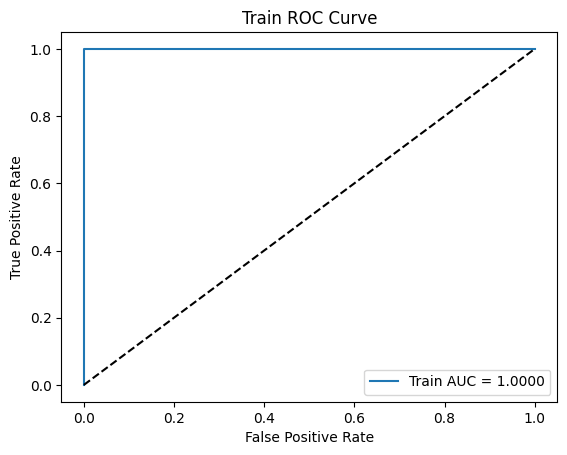


==== Test Set Evaluation==== 
Confusion Matrix:
 [[15609    16]
 [  113   262]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9928    0.9990    0.9959     15625
           1     0.9424    0.6987    0.8025       375

    accuracy                         0.9919     16000
   macro avg     0.9676    0.8488    0.8992     16000
weighted avg     0.9916    0.9919    0.9914     16000

AUC: 0.9890
Misclassification Rate: 0.0081


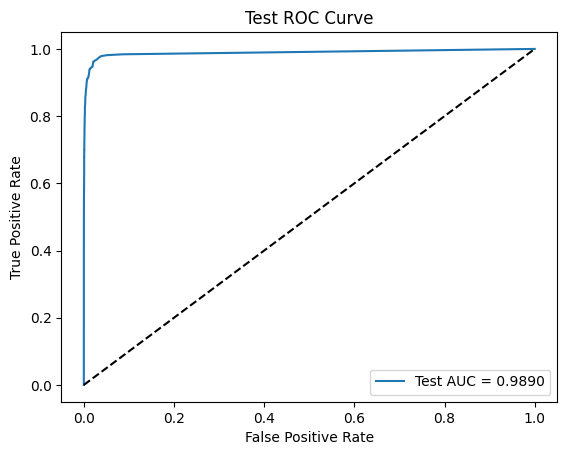

In [58]:
model_para(rf, x_train, y_train, "Train")
model_para(rf, x_test, y_test, "Test")

In [59]:
print(f"OOB Error Rate: {1 - rf.oob_score_:.4f}")
print(f"Misclassification Rate on Test Set: {np.mean(rf.predict(x_test) != y_test):.4f}")

OOB Error Rate: 0.0063
Misclassification Rate on Test Set: 0.0081


## d).

Class imbalanced will make the model go to the majority, in this case, the negative. 


==== Train (Balanced) Set Evaluation==== 
Confusion Matrix:
 [[59000     0]
 [    1   999]]

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     59000
           1     1.0000    0.9990    0.9995      1000

    accuracy                         1.0000     60000
   macro avg     1.0000    0.9995    0.9997     60000
weighted avg     1.0000    1.0000    1.0000     60000

AUC: 1.0000
Misclassification Rate: 0.0000


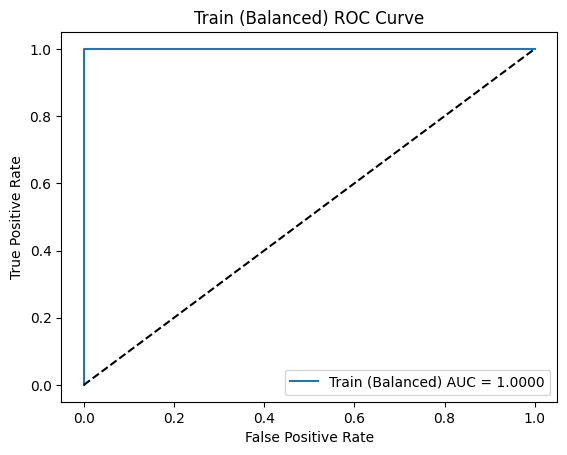


==== Test (Balanced) Set Evaluation==== 
Confusion Matrix:
 [[15607    18]
 [  157   218]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9900    0.9988    0.9944     15625
           1     0.9237    0.5813    0.7136       375

    accuracy                         0.9891     16000
   macro avg     0.9569    0.7901    0.8540     16000
weighted avg     0.9885    0.9891    0.9878     16000

AUC: 0.9902
Misclassification Rate: 0.0109


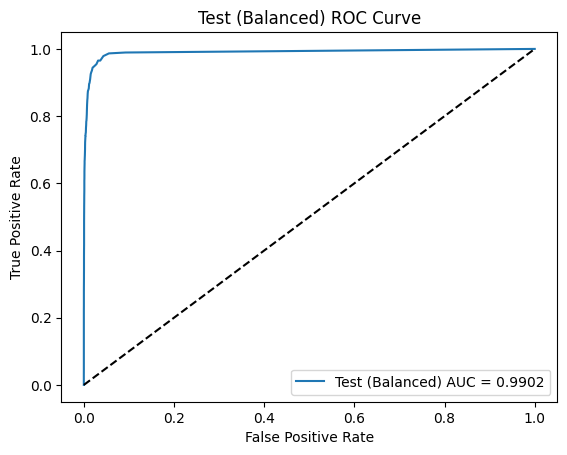

OOB Error Rate (Balanced): 0.0078
Misclassification Rate on Test Set: 0.0109


In [60]:
rf_balanced = RandomForestClassifier(n_estimators=100, oob_score=True, class_weight='balanced', random_state=42)
rf_balanced.fit(x_train, y_train)
model_para(rf_balanced, x_train, y_train, "Train (Balanced)")
model_para(rf_balanced, x_test, y_test, "Test (Balanced)")

print(f"OOB Error Rate (Balanced): {1 - rf_balanced.oob_score_:.4f}")
print(f"Misclassification Rate on Test Set: {np.mean(rf_balanced.predict(x_test) != y_test):.4f}")

Compare to 1c, 1d's misclassification rate and OOB error rate have bigger differences. The model is still good.

## e).

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [19:20:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best alpha: 10
Best AUC in CV: 0.9892499152542372


C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [19:20:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



==== Train Set Evaluation==== 
Confusion Matrix:
 [[58985    15]
 [  120   880]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9980    0.9997    0.9989     59000
           1     0.9832    0.8800    0.9288      1000

    accuracy                         0.9978     60000
   macro avg     0.9906    0.9399    0.9638     60000
weighted avg     0.9977    0.9978    0.9977     60000

AUC: 0.9983
Misclassification Rate: 0.0022


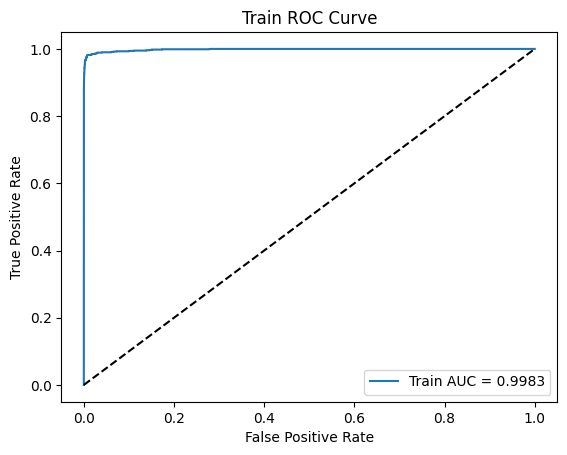


==== Test Set Evaluation==== 
Confusion Matrix:
 [[15552    73]
 [  122   253]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9922    0.9953    0.9938     15625
           1     0.7761    0.6747    0.7218       375

    accuracy                         0.9878     16000
   macro avg     0.8841    0.8350    0.8578     16000
weighted avg     0.9872    0.9878    0.9874     16000

AUC: 0.9912
Misclassification Rate: 0.0122


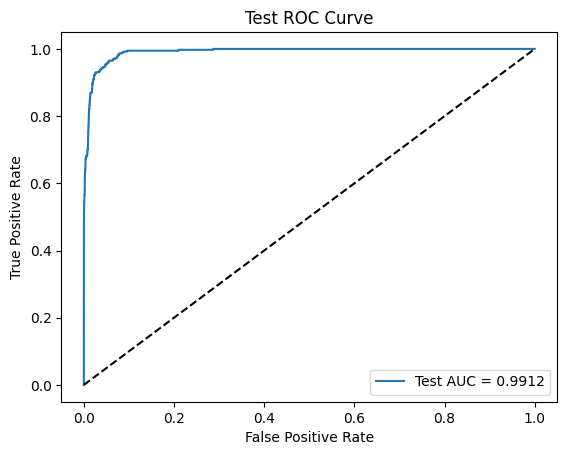

In [62]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
    random_state=42
)
param_grid = {'alpha': [0.01, 0.1, 1, 5, 10]}
crossvalidation = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc', 
    cv=crossvalidation,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print("Best alpha:", grid_search.best_params_['alpha'])
print("Best AUC in CV:", grid_search.best_score_)
best_model = grid_search.best_estimator_
best_model.fit(x_train, y_train)
model_para(best_model, x_train, y_train, "Train")
model_para(best_model, x_test, y_test, "Test")


### f).

In [63]:
smote = SMOTE(random_state=42)
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
    random_state=42
)

pipeline = Pipeline([
    ('smote', smote),
    ('xgb', xgb_model)
])
param_grid = {'xgb__reg_alpha': [0.01, 0.1, 1, 5, 10]}
crossvalidation = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=crossvalidation,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\wuxul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [19:21:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',...
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1, param_grid={'xgb__reg_alpha': [0.01, 0.1, 1, 5, 10]},
             scoring='roc_auc', verbose=1)


==== Train (SMOTE) Set Evaluation==== 
Confusion Matrix:
 [[58948    52]
 [   26   974]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9996    0.9991    0.9993     59000
           1     0.9493    0.9740    0.9615      1000

    accuracy                         0.9987     60000
   macro avg     0.9744    0.9866    0.9804     60000
weighted avg     0.9987    0.9987    0.9987     60000

AUC: 0.9998
Misclassification Rate: 0.0013


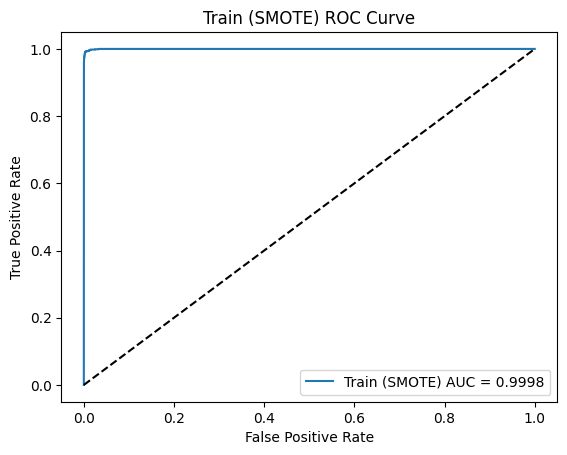


==== Test (SMOTE) Set Evaluation==== 
Confusion Matrix:
 [[15280   345]
 [   51   324]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9967    0.9779    0.9872     15625
           1     0.4843    0.8640    0.6207       375

    accuracy                         0.9752     16000
   macro avg     0.7405    0.9210    0.8039     16000
weighted avg     0.9847    0.9752    0.9786     16000

AUC: 0.9850
Misclassification Rate: 0.0248


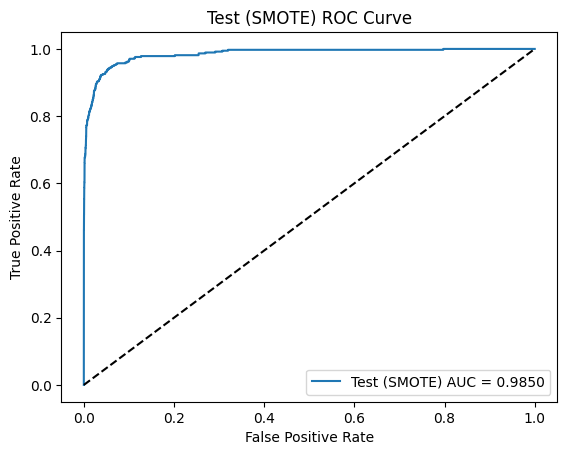

In [64]:
best_model = grid_search.best_estimator_
model_para(best_model, x_train, y_train, "Train (SMOTE)")
model_para(best_model, x_test, y_test, "Test (SMOTE)")


Compare to the uncompensated case, we have a small increase on recall rate for positive, and the model is still accurate, but have a big decrease on precision.

REFERENCE: 
    print(f"\n {dataset_name} Set Evaluation ")
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    report = classification_report(y_true, y_pred, digits=4)
    print("\nClassification Report:\n", report)
    auc_score = roc_auc_score(y_true, y_proba)
    print(f"AUC: {auc_score:.4f}")
    misclassification_rate = np.mean(y_pred != y_true)
    print(f"Misclassification Rate: {misclassification_rate:.4f}")

    Chatgpt help me writting the function and make the output look nice.

# 2. ISLR 6.6.3

a):iv. If s increase, the parameters can be non-zeros and model can fit better, so rss steadly decrease.   <br>
b):ii. The model will fit first then become overfit.  <br> 
c):iii. With s goes up, the model become more complex and variance will goes up.  <br> 
d):iv. Model can fit better, bias will decrease.  <br> 
e):v. Does not relate to s, remain the same.   <br> 

# 3. ISLR 6.6.5 

#### a). 
$$
\min_{\beta_1, \beta_2} \left[ \sum_{i=1}^2 \left( y_i - z_i(\beta_1 + \beta_2) \right)^2 + \lambda(\beta_1^2 + \beta_2^2) \right]
$$


#### b). 
Since the prediction depends only on 
$$ 
{ \beta_1 + \beta_2 } 
$$ , the loss is constant for any pair with the same sum.
It is minimized when 
$$ 
{ \beta_1 = \beta_2 } 
$$

#### c). 
$$
\min_{\beta_1, \beta_2} \left[ \sum_{i=1}^2 (y_i - z_i(\beta_1 + \beta_2))^2 \right] \quad \text{subject to} \quad |\beta_1| + |\beta_2| \leq s
$$


#### d). 
Since the prediction depends only on
$$
\beta_1 + \beta_2 = C
$$
and the L1 constraint allows many such combinations that satisfy
$$
|\beta_1| + |\beta_2| \leq s,
$$
we can have multiple valid solutions.

**Example valid solutions:**

$$
\beta_1 = 1, \beta_2 = 0 ; 
$$
$$
\beta_1 = 0.5, \beta_2 = 0.5 ; 
$$
$$
\beta_1 = 0, \beta_2 = 1 ; 
$$




## 4. ISLR 8.4.5

Majority Vote: Let's say the number bigger than 0.5 is red, then we have 6 number (0.55,0.6,0.6,0.65,0.7,0.75) is red and 4 number is green. In this case, the Majority is red; <br>

Average Probability: Still, bigger than 0.5 is red and under 0.5 is green. The mean of the 10 samples are 0.45, which smaller than 0.5, so it is green.


## 5. ISLR 9.7.3

#### a).

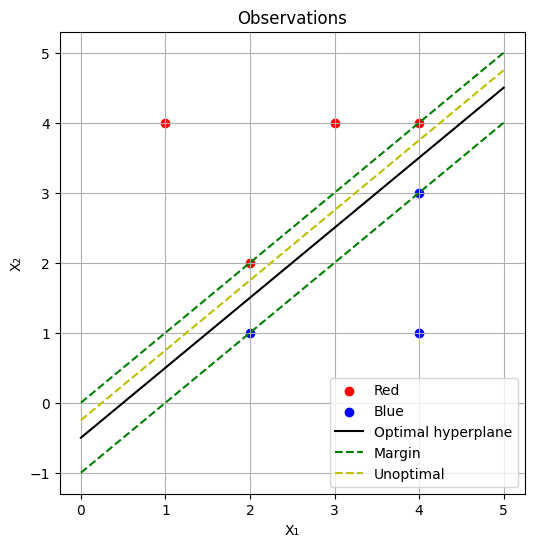

In [65]:
x = [[3,4],[2,2],[4,4],[1,4],[2,1],[4,3],[4,1]]
y = ['Red','Red','Red','Red','Blue','Blue','Blue']
reds = [x[i] for i in range(len(y)) if y[i]=='Red']
blues = [x[i] for i in range(len(y)) if y[i]=='Blue']

x_vals = np.linspace(0, 5, 100)
y_vals = x_vals - 0.5 
y_vals_margin1 = x_vals - 0.5 - 0.5  
y_vals_margin2 = x_vals - 0.5 + 0.5  
y_vals_unoptimal = x_vals - 0.25  
plt.figure(figsize=(6,6))
plt.scatter(*zip(*reds), color='red', label='Red')
plt.scatter(*zip(*blues), color='blue', label='Blue')
plt.plot(x_vals, y_vals, 'k', label='Optimal hyperplane')
plt.plot(x_vals, y_vals_margin1, 'g--', label='Margin')
plt.plot(x_vals, y_vals_margin2, 'g--')
plt.plot(x_vals, y_vals_unoptimal, 'y--', label='Unoptimal')
plt.xlabel("X₁")
plt.ylabel("X₂")
plt.legend()
plt.grid(True)
plt.title("Observations")
plt.show()

The equation here is 0.5-x1+x2=0

#### b). Shown in the graph in a).
The black line is the optimal separating hyperplane

#### c). 
Classify to Red if 0.5 -X1 + X2 > 0, and classify to Blue otherwise. <br>
β0 = 0.5 <br> 
β1 = -1 <br>
β2 = 1 <br>

#### d). Shown in the graph in a).
The two green line are the maximal margin hyperplane.

#### e).
Support vector are x1 = 4, x2 = 4; x1 = 2, x2 = 2; x1 = 4, x2 = 3; x1 = 2, x2 = 1;

#### f).
The 7th observation is x1 = 4, x2 = 1, which is relatively far from the support vector, so slight movement won't affect the hyperplane.

#### g). Shown in the graph in a).
The yellow line is the hyperplane that is not optimal. <br>
β0 = 0.25 <br> 
β1 = -1 <br>
β2 = 1 <br>


#### h).

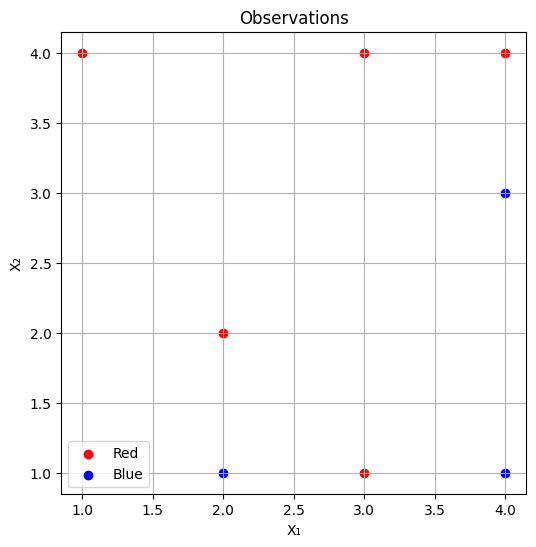

In [66]:
x = [[3,4],[2,2],[4,4],[1,4],[2,1],[4,3],[4,1],[3,1]]
y = ['Red','Red','Red','Red','Blue','Blue','Blue','Red']
reds = [x[i] for i in range(len(y)) if y[i]=='Red']
blues = [x[i] for i in range(len(y)) if y[i]=='Blue']

plt.figure(figsize=(6,6))
plt.scatter(*zip(*reds), color='red', label='Red')
plt.scatter(*zip(*blues), color='blue', label='Blue')
plt.xlabel("X₁")
plt.ylabel("X₂")
plt.legend()
plt.grid(True)
plt.title("Observations")
plt.show()

As shown above, the new observation is x1 = 3, x2 = 1 and y is red, which can make two classes can not separate by a hyperplane.